In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
from glob import glob
from tqdm import tqdm, trange

In [41]:
images = [cv2.imread(file,0) for file in sorted(glob('output/simulated/*'))]
# size = images[0].shape
# images = [image[:size[0]//2,:size[1]//2] for image in images]

In [42]:
def sift_matching_with_homography(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

    if len(good_matches) > 10:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H
    else:
        return None

In [43]:
sift = cv2.SIFT_create(nfeatures=1000)
def get_sift_features(image):
    return sift.detectAndCompute(image, None)

def match_sift_features(feat1, feat2, use_knn=False):
    keypoints1, descriptors1 = feat1
    keypoints2, descriptors2 = feat2
    if use_knn:
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    else:
        bf = cv2.BFMatcher()
        matches1 = bf.knnMatch(descriptors1, descriptors2, 2)
        matches2 = bf.knnMatch(descriptors2, descriptors1, 2)

        # Apply ratio test and cross-checking
        good_matches = []
        for m, n in matches1:
            if m.distance < 0.75 * n.distance:
                for n_match in matches2[m.trainIdx]:
                    if n_match.trainIdx == m.queryIdx:
                        good_matches.append(m)

    if len(good_matches) > 10:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H, np.mean(mask), np.sum(mask)
    else:
        return np.eye(3), 0, 0

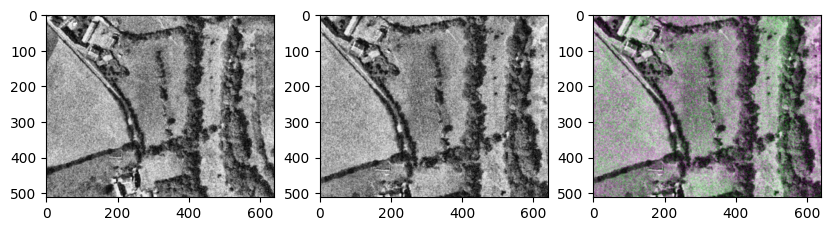

In [44]:
im0 = images[8]
im1 = images[9]
feat1 = get_sift_features(im0)
feat2 = get_sift_features(im1)
H, score, _ = match_sift_features(feat1, feat2)
im2 = cv2.warpPerspective(im0,H,(im1.shape[1],im1.shape[0]))
im3 = np.stack([im1,im2,im1],axis=-1)

fig, ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im0,cmap='gray')
ax[1].imshow(im1,cmap='gray')
ax[2].imshow(im3)


In [45]:
features = []

for image in tqdm(images):
    features.append(get_sift_features(image))

N = 30

inliers = np.zeros([N,N])
ratios = np.zeros([N,N])
Hs = []

for i in trange(N):
    for j in range(i):
        H, score, inlier = match_sift_features(features[i], features[j])
        ratios[i,j] = score
        inliers[i,j] = inlier


100%|██████████| 30/30 [00:01<00:00, 27.38it/s]


In [46]:
temp = np.minimum(ratios,inliers/100)
scores = -np.log(temp + temp.T)
# scores = -np.log(ratios + ratios.T)
# scores = -np.log(inliers + inliers.T)

/tmp/ipykernel_52007/373129790.py:2: RuntimeWarning: divide by zero encountered in log
  scores = -np.log(temp + temp.T)


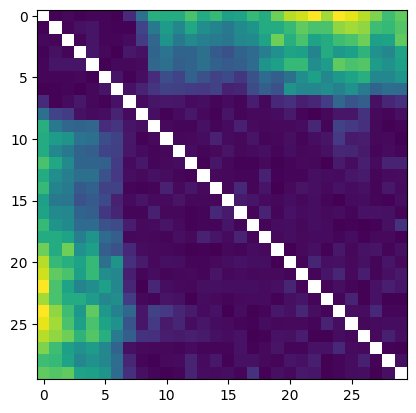

In [47]:
plt.imshow(scores)

In [48]:
import numpy as np
import networkx as nx

def lightest_path(adj_matrix, source, target):
    # Create a graph from the adjacency matrix
    G = nx.Graph()
    num_nodes = len(adj_matrix)
    
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_matrix[i][j] != 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])
    
    # Find the lightest path
    lightest_path = nx.shortest_path(G, source=source, target=target, weight='weight')
    
    # Calculate the total weight of the lightest path
    total_weight = nx.shortest_path_length(G, source=source, target=target, weight='weight')
    
    return lightest_path, total_weight

1 [0, 1] 0.14317217186520878
2 [0, 2] 0.16453852113757117
3 [0, 3] 0.1423792229688614
4 [0, 4] 0.1589740024595512
5 [0, 5] 0.15806380095476122
6 [0, 6] 0.1348467313301682
7 [0, 1, 7] 0.2816384526930048
8 [0, 4, 8] 0.34065203347381845
9 [0, 1, 7, 9] 0.5197887911738219
10 [0, 4, 8, 10] 0.47746600659653476
11 [0, 4, 8, 11] 0.5253932619289091
12 [0, 1, 7, 12] 0.4591966870388793
13 [0, 1, 7, 13] 0.47927692225692087
14 [0, 1, 7, 14] 0.4285954357807758
15 [0, 6, 15] 0.44556776264582076


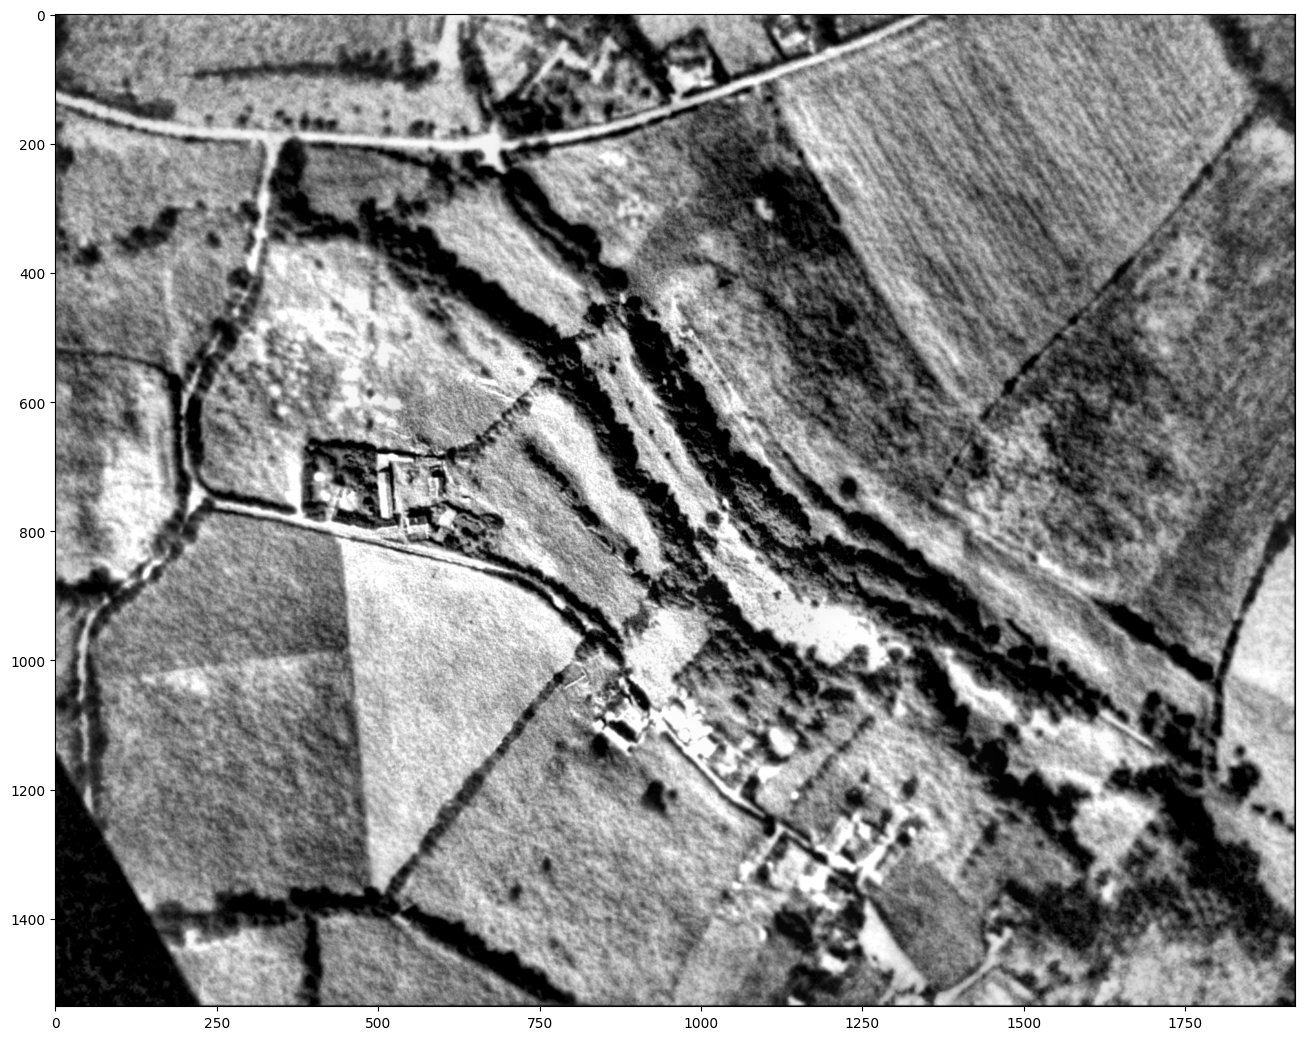

In [49]:
aligned_images = []
upscale = 3.0
new_shape = (int(images[0].shape[1]*upscale),int(images[0].shape[0]*upscale))
H_upscale = np.diag([upscale,upscale,1])

for i in range(0,16):
    start = 0
    end = i
    H = np.eye(3)
    if i > 0:
        path, weight = lightest_path(scores + 0.1, start, end)
        print(i, path, weight)
        
        H = np.eye(3)
        for j in range(1,len(path)):
            H_rel, _, _ = match_sift_features(features[path[j]], features[path[j-1]])
            H = H @ H_rel
    
    im = cv2.warpPerspective(images[i],H_upscale @ H,new_shape)
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    aligned_images.append(im)

def poisson_blend(img1, img2, mask):
    img1 = np.float32(img1)
    img2 = np.float32(img2)
    mask = np.float32(mask)
    laplacian1 = cv2.Laplacian(img1, cv2.CV_32F, ksize=3)
    laplacian2 = cv2.Laplacian(img2, cv2.CV_32F, ksize=3)
    blended_laplacian = (laplacian1 * (1 - mask)) + (laplacian2 * mask)
    blended_img = cv2.add(img1, blended_laplacian)
    blended_img = np.clip(blended_img, 0, 255).astype(np.uint8)
    return blended_img

sum_image = aligned_images[0].copy()
center = (sum_image.shape[1]//2, sum_image.shape[0]//2)
for image in aligned_images:
    mask = ((image > 0)*255).astype(np.uint8)
    mask = cv2.erode(mask.astype(np.uint8),np.ones((5,5),np.uint8))[:,:,0]
    # sum_image[mask>0] = image[mask>0]
    # sum_image = poisson_blend(sum_image,image,mask)
    # status, sum_image = stitcher.stitch([sum_image,image])
    # print(mask.shape, image.shape, sum_image.shape)
    br = cv2.boundingRect(mask) # bounding rect (x,y,width,height)
    centerOfBR = (br[0] + br[2] // 2, br[1] + br[3] // 2)
    sum_image = cv2.seamlessClone(image,sum_image,mask, centerOfBR, cv2.MIXED_CLONE)

plt.figure(figsize=(16,16))
plt.imshow(sum_image,cmap='gray')

# fig, ax = plt.subplots(4,4,figsize=(10,10))
# for i in range(4):
#     for j in range(4):
#         im0 = images[0]
#         im1 = aligned_images[i*4+j]
#         im2 = np.stack([im0,im1,im0],axis=-1)
#         ax[i,j].imshow(im2,cmap='gray')
#         ax[i,j].axis('off')
#         ax[i,j].set_title(f'Image {i*4+j}')

    

In [242]:
np.sqrt(np.linalg.det(H[:2,:2]))

0.2997076412764104

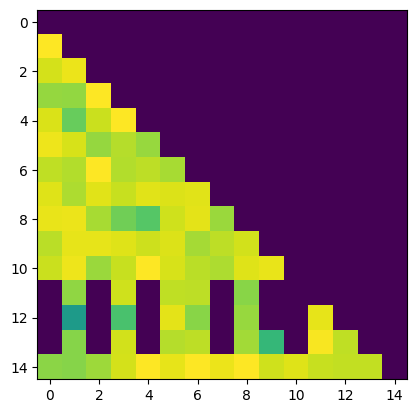

In [42]:
# plot the scores
plt.imshow(ratios)


In [ ]:
# dynamic algorithm, score[i,j] = max()

In [21]:
import numpy as np

def maximize_score(adj_matrix, start, end):
    num_nodes = len(adj_matrix)
    
    # Initialize scores and predecessor nodes
    scores = np.zeros(num_nodes)
    predecessors = [-1] * num_nodes
    scores[start] = 1
    
    # Dynamic programming to compute maximum score and predecessor for each node
    for _ in range(num_nodes - 1):
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_matrix[i][j] != 0:
                    new_score = scores[i] * adj_matrix[i][j]
                    if new_score > scores[j]:
                        scores[j] = new_score
                        predecessors[j] = i
    
    # Reconstruct the optimal path
    optimal_path = []
    current_node = end
    while current_node != -1:
        optimal_path.append(current_node)
        current_node = predecessors[current_node]
    optimal_path.reverse()
    
    return scores[end], optimal_path

# Example usage
adj_matrix = scores.T
start = 0
end = 11
max_score, optimal_path = maximize_score(adj_matrix, start, end)
print("Maximum score:", max_score)
print("Optimal path:", optimal_path)


Maximum score: 0.9109730848861284
Optimal path: [0, 2, 6, 11]


In [28]:
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree

def maximize_score_with_spanning_tree(adj_matrix, start, end):
    num_nodes = len(adj_matrix)
    
    # Compute the minimum spanning tree
    mst_matrix = minimum_spanning_tree(adj_matrix).toarray().astype(float)
    
    # Initialize scores and spanning tree
    scores = np.zeros(num_nodes)
    spanning_tree = [[] for _ in range(num_nodes)]
    scores[start] = 1
    
    # Dynamic programming to compute maximum score and spanning tree
    for _ in range(num_nodes - 1):
        for i in range(num_nodes):
            for j in range(num_nodes):
                if mst_matrix[i][j] != 0:
                    new_score = scores[i] * mst_matrix[i][j]
                    if new_score > scores[j]:
                        scores[j] = new_score
                        spanning_tree[j] = spanning_tree[i] + [(i, j)]
    
    # Add edges to connect remaining isolated nodes
    for i in range(num_nodes):
        if not spanning_tree[i]:
            for j in range(num_nodes):
                if i != j:
                    spanning_tree[i].append((i, j))
    
    # Reconstruct the optimal spanning tree
    optimal_spanning_tree = spanning_tree[end]
    
    return scores[end], optimal_spanning_tree

# Example usage
adj_matrix = scores.T
start = 0
end = 11
max_score, optimal_spanning_tree = maximize_score_with_spanning_tree(adj_matrix, start, end)
print("Maximum score:", max_score)
print("Optimal spanning tree:", optimal_spanning_tree)


Maximum score: 0.0
Optimal spanning tree: [(11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 12), (11, 13), (11, 14)]


array([0., 0., 0., 0.])

In [43]:
inliers = ratios.copy()

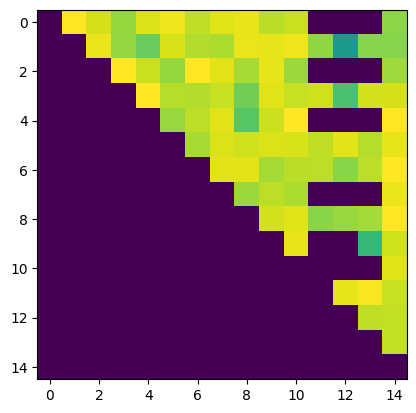

In [46]:
plt.imshow(ratios.T)

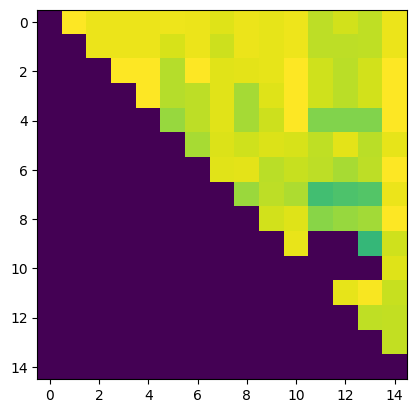

In [47]:
plt.imshow(scores)

In [61]:
import networkx as nx

def minimal_spanning_tree(adj_matrix):
    # Create a graph from the adjacency matrix
    G = nx.Graph()
    num_nodes = len(adj_matrix)
    
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_matrix[i][j] != 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])
    
    mst = nx.minimum_spanning_tree(G)
    
    # Convert EdgeDataView to a list of edges
    mst_edges = list(mst.edges(data=True))
    
    return mst_edges


def create_symmetric_matrix(top_matrix):
    n = len(top_matrix)
    sym_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            sym_matrix[i][j] = top_matrix[i][j]
    sym_matrix += sym_matrix.T
    return sym_matrix


adjacency = create_symmetric_matrix(ratios.T)

In [64]:
scores = -np.log(adjacency)
tree = minimal_spanning_tree(scores)
nodes = [(x[0], x[1]) for x in tree]
print(nodes)


[(0, 5), (0, 8), (2, 1), (3, 9), (4, 7), (5, 14), (5, 12), (6, 8), (7, 14), (8, 1), (9, 10), (10, 1), (11, 13), (11, 12)]


/tmp/ipykernel_34426/276787354.py:1: RuntimeWarning: divide by zero encountered in log
  scores = -np.log(adjacency)


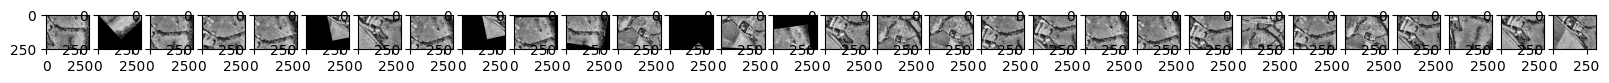

In [66]:
# align all the images to 0 based on nodes
aligned_images = [images[0]]
for i in range(1,len(images)):
    H = np.eye(3)
    for node in nodes:
        if node[1] == i:
            H = np.dot(H, match_sift_features(features[node[0]], features[node[1]])[0])
    aligned_images.append(cv2.warpPerspective(images[i],H,(images[0].shape[1],images[0].shape[0])))

# plot the aligned images
fig, ax = plt.subplots(1,len(aligned_images),figsize=(20,20))
for i in range(len(aligned_images)):
    ax[i].imshow(aligned_images[i],cmap='gray')
                          

In [ ]:
def maximize_score_with_spanning_tree(adj_matrix, start, end):
    num_nodes = len(adj_matrix)
    
    # Initialize scores and spanning tree
    scores = np.zeros(num_nodes)
    spanning_tree = [[] for _ in range(num_nodes)]
    scores[start] = 1
    
    # Dynamic programming to compute maximum score and spanning tree
    for _ in range(num_nodes - 1):
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_matrix[i][j] != 0:
                    new_score = scores[i] * adj_matrix[i][j]
                    if new_score > scores[j]:
                        scores[j] = new_score
                        spanning_tree[j] = spanning_tree[i] + [(i, j)]
    
    # Reconstruct the optimal spanning tree
    optimal_spanning_tree = spanning_tree[end]
    
    return scores[end], optimal_spanning_tree

In [69]:
N

15

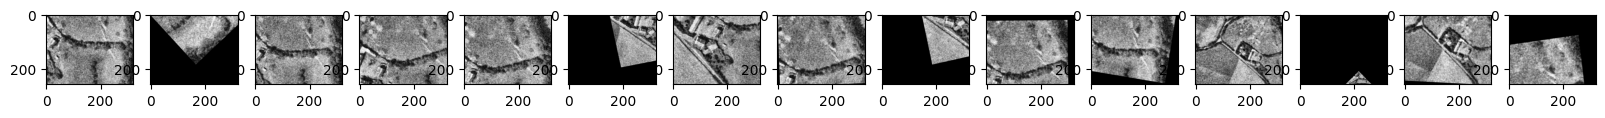

In [71]:
def maximize_score_with_spanning_tree(adj_matrix, start, end):
    num_nodes = len(adj_matrix)
    
    # Initialize scores and spanning tree
    scores = np.zeros(num_nodes)
    spanning_tree = [[] for _ in range(num_nodes)]
    scores[start] = 1
    
    # Dynamic programming to compute maximum score and spanning tree
    for _ in range(num_nodes - 1):
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_matrix[i][j] != 0:
                    new_score = scores[i] * adj_matrix[i][j]
                    if new_score > scores[j]:
                        scores[j] = new_score
                        spanning_tree[j] = spanning_tree[i] + [(i, j)]
    
    # Reconstruct the optimal spanning tree
    optimal_spanning_tree = spanning_tree[end]
    
    return scores[end], optimal_spanning_tree

for num_image in range(N):
    adj_matrix = ratios.T
    start = 0
    end = num_image
    max_score, optimal_spanning_tree = maximize_score_with_spanning_tree(adj_matrix, start, end)
    
    # warp the image
    H = np.eye(3)
    for node in optimal_spanning_tree:
        H = np.dot(H, match_sift_features(features[node[0]], features[node[1]])[0])
    H = np.linalg.inv(H) 
    aligned_images.append(cv2.warpPerspective(images[num_image],H,(images[0].shape[1],images[0].shape[0])))

# plot the aligned images
fig, ax = plt.subplots(1,N,figsize=(20,20))
for i in range(N):
    ax[i].imshow(aligned_images[i],cmap='gray')
